In [1]:
# Cell 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("ライブラリ読み込み完了")
import japanize_matplotlib

ライブラリ読み込み完了


In [2]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

# モック

[501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716]
501 6899


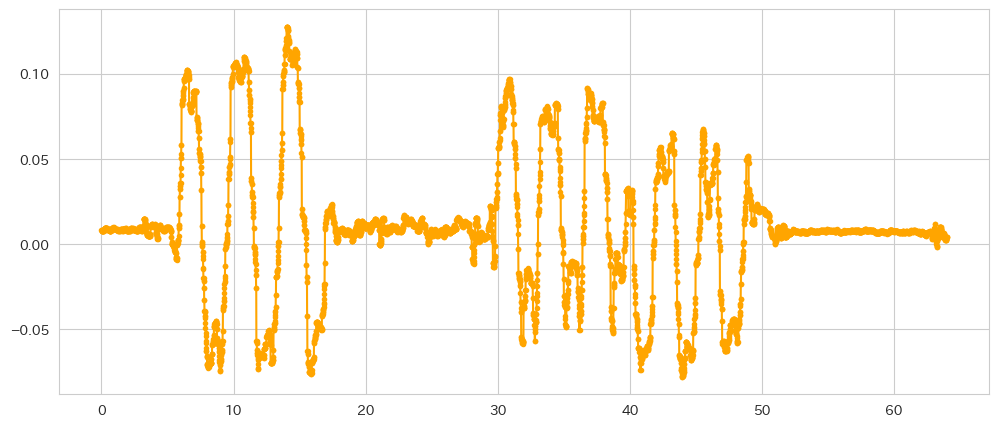

In [3]:
seat_path = r"C:\Users\youli\Desktop\code\copmodoki\2F\1_20251118_2F_takemura_動き大_2_OK.csv"
pedal_path = r"C:\Users\youli\Desktop\code\copmodoki\2F\pedal_20251118_1629340.csv"
cop_path = r"C:\Users\youli\Desktop\code\copmodoki\2F\seat_20251118_1629340.csv"
steer_path = r"C:\Users\youli\Desktop\code\copmodoki\2F\steer_20251118_1629340.csv"
df_seat = pd.read_csv(seat_path,skiprows=1)
df_pedal = pd.read_csv(pedal_path,skiprows=21)
df_cop = pd.read_csv(cop_path,skiprows=21)
df_steer = pd.read_csv(steer_path,skiprows=21)
df_pedal.rename(columns={'Untitled 4':'pedal'},inplace=True)
df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
df_cop.rename(columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)
df_pedal = make_time_row(df_pedal)
df_steer = make_time_row(df_steer)
df_cop = make_time_row(df_cop)


df_mock = pd.merge(df_cop[['time','COP_X','COP_Y']], df_steer[['time','steer','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
df_mock = pd.merge(df_mock, df_pedal[['time','pedal']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
plt.plot(df_mock_tmp.time,df_mock_tmp['COP_X'],'.-',color='orange')


# シート圧センサ

In [4]:
import re

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

df_seat = fix_columns(df_seat)


Sampling rate: 41.66666666666509 Hz


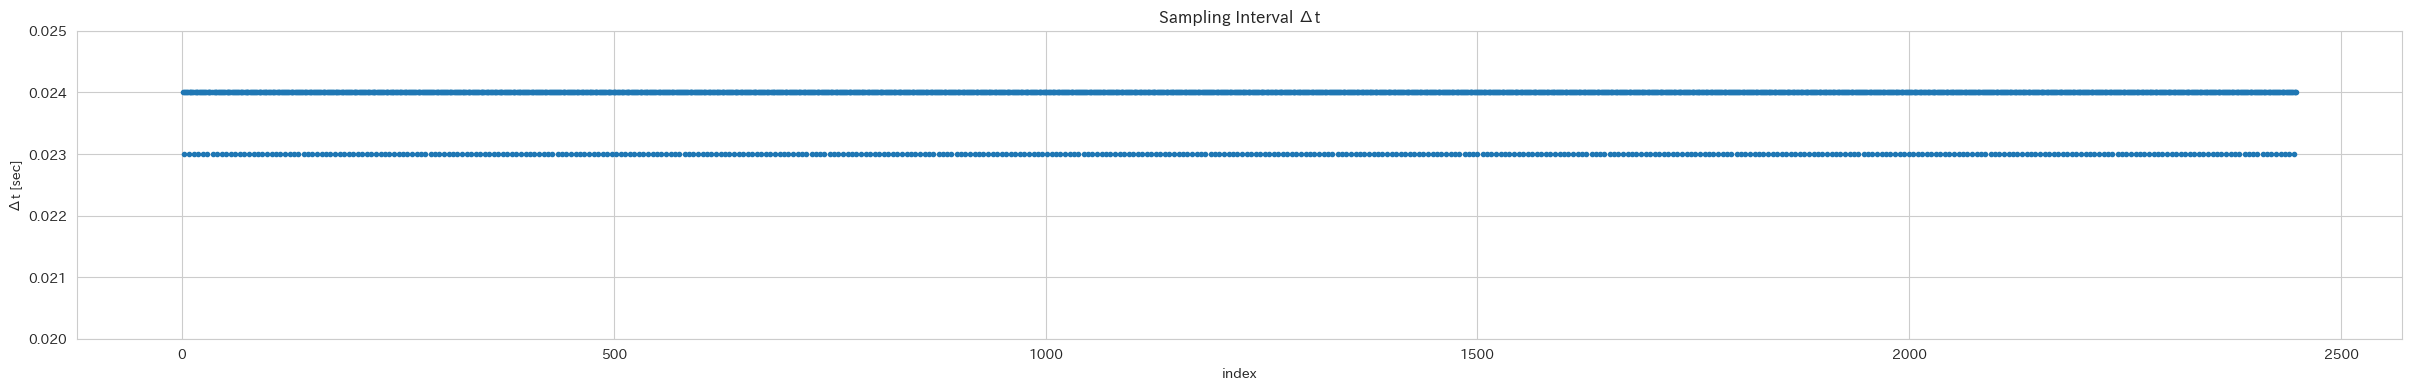

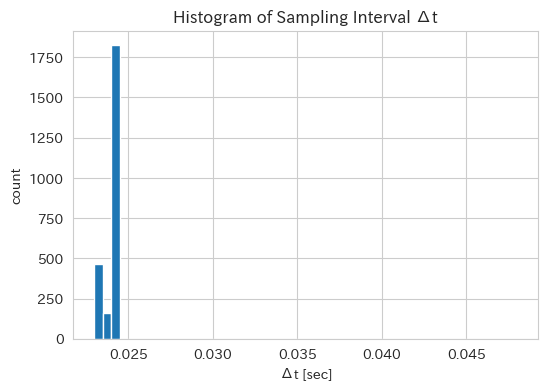

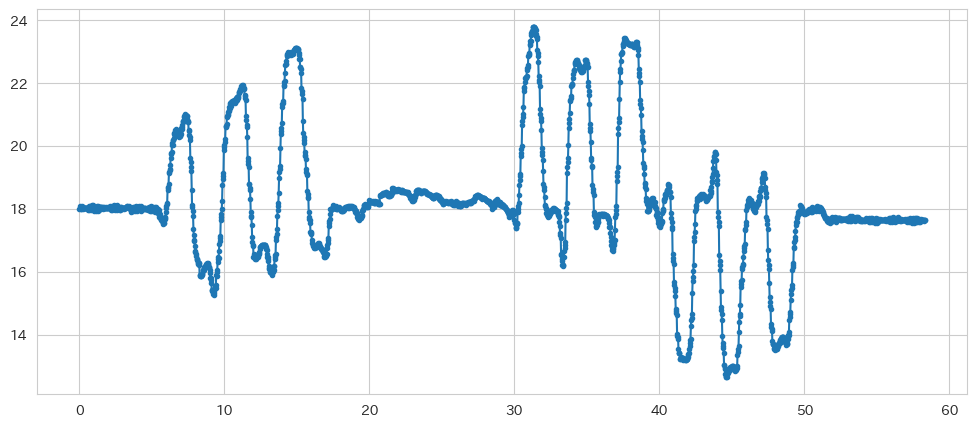

In [5]:
df_seat['time'] = df_seat['時間_1']

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med

fs, dt = estimate_sampling_rate(df_seat)
print("Sampling rate:", fs, "Hz")

# time 差分（サンプリング間隔）
dt = df_seat['time'].diff()

plt.figure(figsize=(30,4))
plt.plot(dt,'.')
plt.title("Sampling Interval Δt")
plt.xlabel("index")
plt.ylabel("Δt [sec]")
plt.ylim(0.020,0.025)
plt.grid(True)
plt.show()


plt.figure(figsize=(6,4))
plt.hist(dt.dropna(), bins=50)
plt.title("Histogram of Sampling Interval Δt")
plt.xlabel("Δt [sec]")
plt.ylabel("count")
plt.grid(True)
plt.show()



plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

# リサンプリング

In [6]:
# from scipy import interpolate

# def resample_by_interpolation(df, time_col, use_cols, target_fs, kind="linear"):
#     """
#     時間列に基づいて use_cols を補間し、指定サンプリング周波数へ変換する関数

#     Parameters
#     ----------
#     df : pd.DataFrame
#         元データ
#     time_col : str
#         時間列のカラム名（例: 'time'）
#     use_cols : list
#         補間対象のカラム名リスト
#     target_fs : float
#         変換後のサンプリングレート (Hz)
#     kind : str
#         'linear', 'cubic', 'nearest' など scipy.interpolate.interp1d の補間方法

#     Returns
#     -------
#     pd.DataFrame
#         補間後の新しい DataFrame（time と use_cols を含む）
#     """

#     t = df[time_col].values
#     data = df[use_cols].values
#     # 新しい時間軸
#     new_time = np.arange(t.min(), t.max(), 1.0 / target_fs)
#     # 補間器
#     f = interpolate.interp1d(t, data, axis=0, kind=kind, fill_value="extrapolate")

#     # 補間結果
#     new_values = f(new_time)

#     # DataFrame にまとめる
#     df_new = pd.DataFrame(new_values, columns=use_cols)
#     df_new[time_col] = new_time

#     return df_new


In [7]:
# use_cols = [
#        '平均圧力_1', '最低圧力_1', 'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1',
#        '荷重(N)_1', '標準偏差_1', '平均_1', '圧力中心行_1', '圧力中心列_1', 
#         '平均圧力_2', '最低圧力_2', 'ピーク圧力_2', '接触域 (cm²)_2', '選択領域(cm²)_2',
#        '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2', '圧力中心行_2', '圧力中心列_2']
# df_seat_30 = resample_by_interpolation(
#     df_seat,
#     time_col='time',
#     use_cols=use_cols,
#     target_fs=30,
#     kind='linear'
# )

# print(f"元のデータ数: {len(df_seat)}")
# print(f"30Hz変換後: {len(df_seat_30)}")
# # display(df_seat_30.head())

# df_mock_30 = resample_by_interpolation(
#     df_mock,
#     time_col='time',
#     use_cols=['COP_X', 'COP_Y', 'steer', 'trg', 'pedal'],
#     target_fs=30,
#     kind='linear'
# )
# print(f"元のデータ数: {len(df_mock)}")
# print(f"30Hz変換後: {len(df_mock_30)}")

In [8]:

# df_mock_t = get_first_trigger_segment(df_mock_30, trigger_col="trg", trigger_value=1)

# print(len(df_mock_t))
# df_mock_t['time'] -= df_mock_t['time'].iloc[0]

# 時系列確認

In [9]:
# plt.plot(df_mock_t.time,df_mock_t.COP_X,'.-')
# plt.plot(df_mock_t.time,df_mock_t.trg*0.01)
# plt.show()
# plt.plot(df_seat_30.time,df_seat_30['圧力中心列_2'],'.-',color='orange')
# # plt.plot(df_seat_30.time,df_seat_30['圧力中心列_1'])

In [10]:
# import numpy as np
# import pandas as pd
# from scipy import signal, interpolate

# def calculate_lag(y1, y2, fs):
#     """
#     2つの信号間のラグ（時間ズレ）を相互相関で計算する関数
#     y2 が y1 に対してどれだけ遅れているかを返す
#     """
#     # 相互相関を計算
#     correlation = signal.correlate(y1 - np.mean(y1), y2 - np.mean(y2), mode="full")
#     # 相関が最大となるインデックスを取得
#     lags = signal.correlation_lags(len(y1), len(y2), mode="full")
#     lag_idx = lags[np.argmax(correlation)]
    
#     # 時間に換算 (負の値ならy2が進んでいる、正ならy2が遅れている)
#     return lag_idx / fs

# def correct_clock_drift(df_master, df_slave, time_col, val_col_a,val_col_b, check_duration=5.0):
#     """
#     df_slave の時間軸を df_master に合わせて伸縮（ドリフト補正）する
    
#     Parameters
#     ----------
#     check_duration : float
#         最初と最後のラグを確認するために切り出す秒数（秒）
#     """
#     # 1. 比較のために一時的に共通のハイサンプリングレート(100Hzなど)に揃える
#     #    (ドリフト検知のためだけの簡易リサンプリング)
#     common_fs = 100.0
    
#     # マスタ側の簡易補間関数
#     f_master = interpolate.interp1d(
#         df_master[time_col], df_master[val_col_a], 
#         kind='linear', fill_value="extrapolate"
#     )
#     # スレーブ側の簡易補間関数
#     f_slave = interpolate.interp1d(
#         df_slave[time_col], df_slave[val_col_b], 
#         kind='linear', fill_value="extrapolate"
#     )
    
#     # 全体の終了時刻（短い方に合わせる）
#     t_end = min(df_master[time_col].max(), df_slave[time_col].max())
#     t_start = max(df_master[time_col].min(), df_slave[time_col].min())
    
#     # --- A. 「最初」の部分のラグ計算 ---
#     t_head = np.arange(t_start, t_start + check_duration, 1/common_fs)
#     lag_start = calculate_lag(f_master(t_head), f_slave(t_head), common_fs)
    
#     # --- B. 「最後」の部分のラグ計算 ---
#     t_tail = np.arange(t_end - check_duration, t_end, 1/common_fs)
#     lag_end = calculate_lag(f_master(t_tail), f_slave(t_tail), common_fs)
    
#     print(f"開始時点のズレ: {lag_start:.4f} sec")
#     print(f"終了時点のズレ: {lag_end:.4f} sec")
    
#     # --- C. ドリフト率（スケーリング係数）の算出 ---
#     # 経過時間
#     duration = (t_end - check_duration/2) - (t_start + check_duration/2)
#     # ズレの変化量
#     drift_diff = lag_end - lag_start
    
#     # 補正係数 (1.0 ならズレなし, 1.0001 ならスレーブが少し速いなど)
#     # df_slaveの時間軸をこの係数で割るか掛けるかして調整
#     # (ここでは df_slave の時間が「進みすぎ/遅れすぎ」を補正する比率)
#     drift_rate = 1.0 + (drift_diff / duration)
    
#     print(f"推定ドリフト率: {drift_rate:.8f}")
#     print(f"補正処理を実行します...")

#     # --- D. 時間軸の補正実行 ---
#     df_slave_corrected = df_slave.copy()
    
#     # 1. まず開始時点のオフセット（平行移動）を補正
#     df_slave_corrected[time_col] = df_slave_corrected[time_col] + lag_start
    
#     # 2. 次にドリフト（伸縮）を補正
#     # 基準点(t=0付近)からの距離に対してスケーリングをかける
#     df_slave_corrected[time_col] = df_slave_corrected[time_col] * (1.0 / drift_rate)

#     return df_slave_corrected
# # 
# # --- 実行イメージ ---
# # df_b_fixed = correct_clock_drift(df_a, df_b, 'time', 'sensor_value')
# # この後、df_b_fixed を使って前回のリサンプリング関数を実行する

In [11]:
# t_min = max(df_mock_tmp['time'].min(), df_seat['time'].min())
# t_max = min(df_mock_tmp['time'].max(), df_seat['time'].max())
# df_A2 = df_mock_tmp[(df_mock_tmp['time'] >= t_min) & (df_mock_tmp['time'] <= t_max)]
# df_B2 = df_seat[(df_seat['time'] >= t_min) & (df_seat['time'] <= t_max)]
# df_b_fixed = correct_clock_drift(df_A2, df_B2, 'time', 'COP_X','圧力中心列_2')

# print(t_max)
# plt.plot(df_B2.time,df_B2['圧力中心列_2'],'.-',color='orange')

# # plt.plot(df_b_fixed.time,df_b_fixed['圧力中心列_2'],'.-',color='orange')
# df_b_fixed.time.max()


# マージ

In [12]:

# t_min = max(df_mock_t['time'].min(), df_seat_30['time'].min())
# t_max = min(df_mock_t['time'].max(), df_seat_30['time'].max())

# df_A2 = df_mock_t[(df_mock_t['time'] >= t_min) & (df_mock_t['time'] <= t_max)]
# df_B2 = df_seat_30[(df_seat_30['time'] >= t_min) & (df_seat_30['time'] <= t_max)]


# df_all = pd.merge(df_A2, df_B2, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
# print(len(df_A2),len(df_B2),len(df_all))

# cols = ['平均圧力_1', '最低圧力_1',
#        'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
#        '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
#        '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
#        '圧力中心行_2', '圧力中心列_2']

# df_all[cols] = df_all[cols].interpolate()


In [13]:
# fig = plt.figure(figsize=(15,6))
# ax1 = fig.add_subplot(1, 1, 1)
# ax2 = ax1.twinx() 
# ax1.plot(df_all.time,df_all['COP_Y'],'.-',color='blue',label='COP_Y')
# ax2.plot(df_all['time'],df_all['圧力中心行_2'],'.-',color='orange',label='圧力中心行') 
# ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
# ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
# plt.show()

# fig = plt.figure(figsize=(15,6))
# ax1 = fig.add_subplot(1, 1, 1)
# ax2 = ax1.twinx() 
# ax1.plot(df_all["time"],df_all['COP_X'],'.-',color='blue',label='COP_X')
# ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
# ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
# ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
# plt.show()

In [14]:

# def plot_shifted_cop(df, shift_samples):
#     # シフトした列を追加
#     df_plot = df.copy()
#     df_plot["COP_Y_shift"] = df_plot["COP_Y"].shift(shift_samples)
#     df_plot["COP_X_shift"] = df_plot["COP_X"].shift(shift_samples)

#     # === COP_Y vs 圧力中心行 ===
#     fig = plt.figure(figsize=(15,6))
#     ax1 = fig.add_subplot(1, 1, 1)
#     ax2 = ax1.twinx()
    
#     ax1.plot(df_plot.time, df_plot['COP_Y_shift'], color='blue', label=f'COP_Y (shift={shift_samples})')
#     ax2.plot(df_plot.time, df_plot['圧力中心行_2'], color='orange', label='圧力中心行')

#     ax1.set_title(f"COP_Y Shifted by {shift_samples} samples")
#     ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
#     ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
#     plt.show()

#     # === COP_X vs 圧力中心列 ===
#     fig = plt.figure(figsize=(15,6))
#     ax1 = fig.add_subplot(1, 1, 1)
#     ax2 = ax1.twinx()
    
#     ax1.plot(df_plot.time, df_plot['COP_X_shift'], color='blue', label=f'COP_X (shift={shift_samples})')
#     ax2.plot(df_plot.time, df_plot['圧力中心列_2'], color='orange', label='圧力中心列')

#     ax1.set_title(f"COP_X Shifted by {shift_samples} samples")
#     ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
#     ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
#     plt.show()

#     return df_plot
# df_shift = plot_shifted_cop(df_all, shift_samples=10)


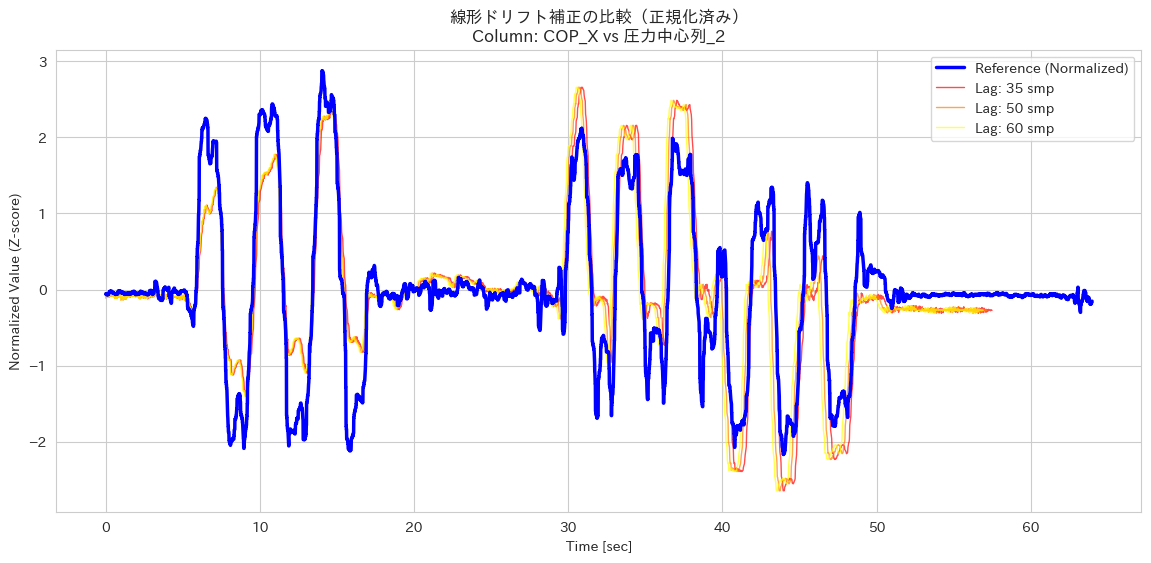

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def visualize_linear_drifts_normalized(df_ref, df_target, drift_samples_list, 
                                     col_ref='COP_X', col_target='圧力中心列_2'):
    """
    線形ドリフトの比較（正規化付き）
    縦軸のスケールが異なるデータを、正規化して重ね書きします。
    """
    
    # --- 1. 前処理: 正規化 (Z-score normalization) ---
    # 平均を引いて標準偏差で割ることで、両方の波形を似たようなサイズにします
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    plt.figure(figsize=(14, 6))
    
    # --- 3. 正解データのプロット（青・太線） ---
    # 正規化した値を使います
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=2.5, label='Reference (Normalized)', zorder=10)
    
    # 色の準備
    colors = plt.cm.autumn(np.linspace(0, 1, len(drift_samples_list)))
    
    # --- 4. 各ドリフト量ごとのシミュレーション ---
    for i, drift_samples in enumerate(drift_samples_list):
        
        # ズレ時間の計算
        total_lag_time = drift_samples * dt_mean
        
        # 伸縮率 (Scale Factor)
        scale_factor = duration / (duration + total_lag_time)
        
        # 時間軸の再計算（線形変換）
        # 時間tに応じて補正量が大きくなる
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # プロット（正規化した値 target_norm を使用）
        plt.plot(new_time, target_norm, 
                 color=colors[i], 
                 linewidth=1, 
                 alpha=0.7,
                 linestyle='-',
                 label=f'Lag: {drift_samples} smp')

    # --- 5. 見やすさの調整 ---
    plt.title(f"線形ドリフト補正の比較（正規化済み）\nColumn: {col_ref} vs {col_target}")
    plt.xlabel("Time [sec]")
    plt.ylabel("Normalized Value (Z-score)")
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # ★重要: ズレが顕著な「後半部分」を拡大表示（必要に応じてコメントアウトを外してください）
    # plt.xlim(t_end_orig - 10.0, t_end_orig + 1.0)
    
    plt.show()

# ==========================================
# 実行
# ==========================================

# 試したいサンプルズレのリスト
try_drifts = [35,50,60] 

visualize_linear_drifts_normalized(
    df_mock_tmp, 
    df_seat, 
    try_drifts,
    col_ref='COP_X',         # df_ref (df_mock_tmp) の列名
    col_target='圧力中心列_2' # df_target (df_seat) の列名
)

補正情報:
  - ズレサンプル数: 35.0
  - ズレ時間換算  : 0.8337 sec
  - 適用スケール  : 0.98590415


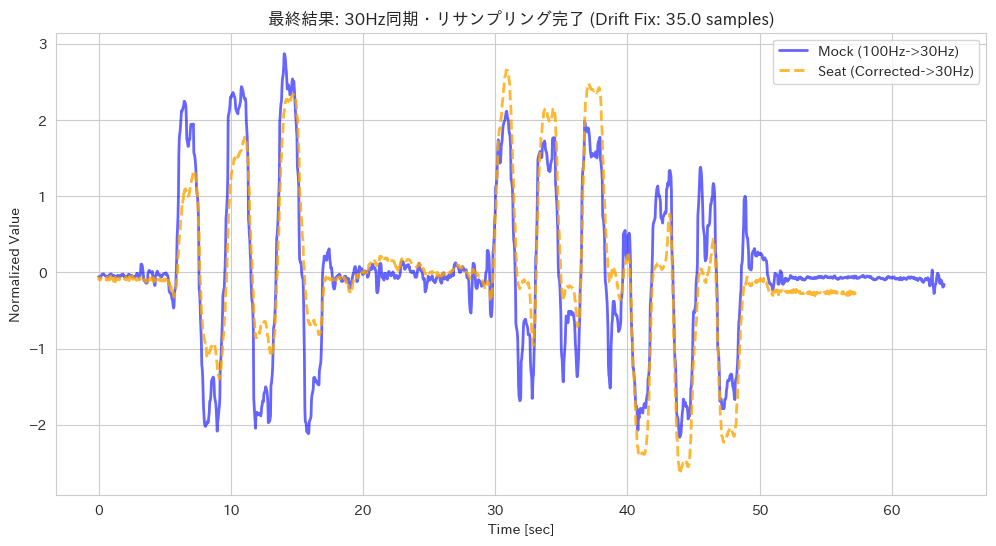

--- df_mock_30hz ---
       time     COP_X     COP_Y     steer       trg     pedal
0  0.000000  0.008135 -0.043596 -0.240790  5.021393  0.371221
1  0.033333  0.008083 -0.043081 -0.555609  5.055865  0.371872
2  0.066667  0.007916 -0.042916 -0.425631  5.047807  0.371873
3  0.100000  0.008033 -0.043076 -0.684502  0.000071  0.371872
4  0.133333  0.007795 -0.043066 -0.686112  0.000068  0.371221

--- df_seat_30hz ---
       time  平均圧力_1  最低圧力_1  ピーク圧力_1  接触域 (cm²)_1  選択領域(cm²)_1     接触 %_1  \
0  0.000000    0.26    0.13     0.62   640.320000      2580.65  24.810000   
1  0.033333    0.26    0.13     0.61   635.121668      2580.65  24.612338   
2  0.066667    0.26    0.13     0.61   630.886612      2580.65  24.448818   
3  0.100000    0.26    0.13     0.61   632.691328      2580.65  24.516074   
4  0.133333    0.26    0.13     0.61   629.505594      2580.65  24.390837   

      荷重(N)_1  標準偏差_1  平均_1  ...  最低圧力_2   ピーク圧力_2  接触域 (cm²)_2  選択領域(cm²)_2  \
0  166.640000     0.1  0.24  ...    0.13  

In [16]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 35.0  # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['COP_X', 'COP_Y', 'steer', 'trg', 'pedal']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_mock_tmp, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)


# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['COP_X']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心列_2']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

In [17]:
df_all = pd.merge(df_mock_30hz, df_seat_30hz, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

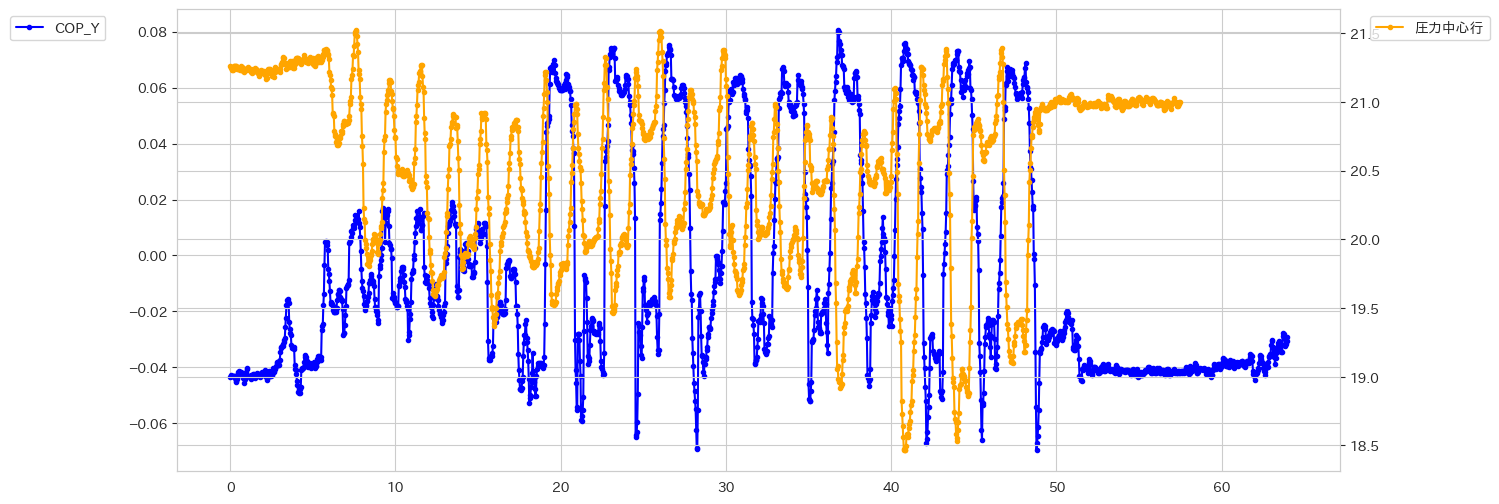

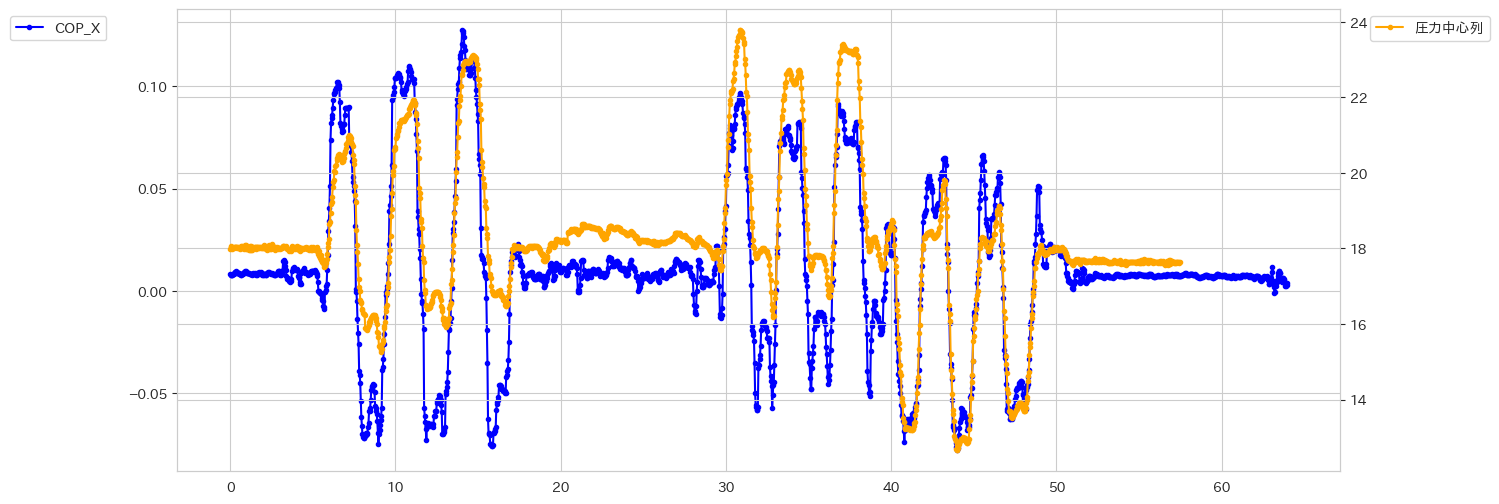

In [18]:

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['COP_Y'],'.-',color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['圧力中心行_2'],'.-',color='orange',label='圧力中心行') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all["time"],df_all['COP_X'],'.-',color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


# 1. データ準備
features = [ 
    'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', 
    '平均圧力_2', 'ピーク圧力_2', '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', 
    '圧力中心行_2', '圧力中心列_2'
]
targets = ['COP_X', 'COP_Y']

# --- ここが修正ポイント: NaNを含む行を削除する ---
# Xとyを結合して、どちらかにNaNがあればその行ごと捨てる
temp_df = df_all[features + targets].dropna()

# 削除後のデータサイズ確認
print(f"元のデータ数: {len(df_all)}")
print(f"NaN除去後のデータ数: {len(temp_df)}")
print(f"削除された行数: {len(df_all) - len(temp_df)}")

if len(temp_df) == 0:
    raise ValueError("すべてがNaNとして削除されました。データの読み込みを確認してください。")

X = temp_df[features]
y = temp_df[targets]

元のデータ数: 1920
NaN除去後のデータ数: 1725
削除された行数: 195


# マルチコ
⑤ 特徴量の共線性（多重共線性の把握）
座圧系の特徴量は相関がめちゃくちゃ強い。
✔ 相関行列とヒートマップ
ここで
相関 0.9 以上のペア
が多いなら、係数の解釈は怪しくなる。

=== 多重共線性（相関 > 0.80）が疑われる特徴量ペア ===
接触 %_1           <->  接触域 (cm²)_1       相関 = 1.000
荷重(N)_1          <->  接触域 (cm²)_1       相関 = 0.947
荷重(N)_1          <->  接触 %_1            相関 = 0.947
接触 %_2           <->  接触域 (cm²)_2       相関 = 1.000


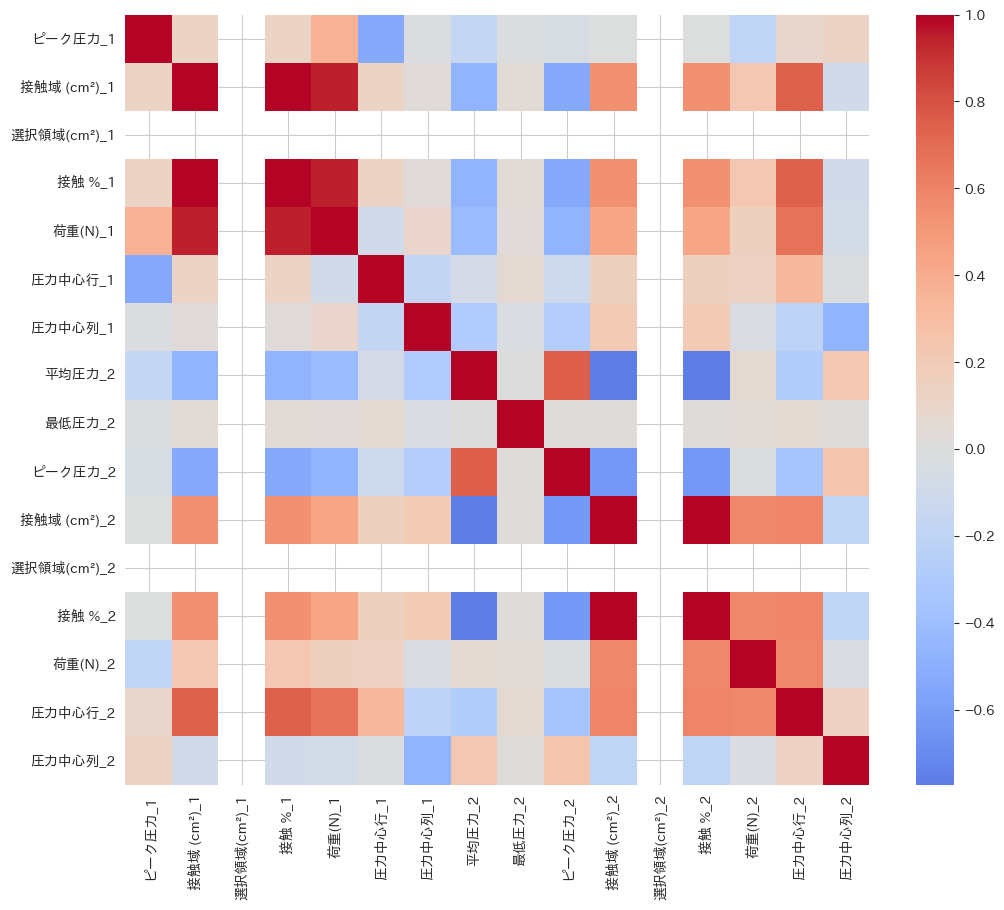

In [31]:
import pandas as pd
import numpy as np

# 相関行列を計算
corr_matrix = temp_df[features].corr().abs()

plt.figure(figsize=(12,10))
sns.heatmap(temp_df[features].corr(), cmap='coolwarm', center=0)

# 上三角行列を抽出（重複と自己相関を除外）
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 閾値（マルチコ検出基準）
threshold = 0.8  # 必要なら 0.9 に変更もOK

# マルチコしてそうなペアを抽出
multicol_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > threshold
]

# 結果表示
print("=== 多重共線性（相関 > {:.2f}）が疑われる特徴量ペア ===".format(threshold))
for f1, f2, corr_value in multicol_pairs:
    print(f"{f1:15s}  <->  {f2:15s}   相関 = {corr_value:.3f}")


「Sanity Check（健全性確認）」**と呼ばれる非常に重要なステップです。「モデルが未知のデータを予測できるか（汎化性能）」を見る前に、まず**「モデルは与えられたデータを丸暗記することすらできないのか？それとも十分に学習できる能力があるのか？」**を確認します。ここで $R^2$ が高ければ、「数理的には解ける問題である（物理的な関係性はデータに含まれている）」ことが確定します。

In [20]:
# # --- Cell 5 (修正版): NaN除去 + In-Sample Evaluation ---



# # 2. 全データを使って学習
# # パイプライン（標準化 -> Ridge回帰）
# full_model = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', Ridge(alpha=1.0))
# ])

# full_model.fit(X, y)

# # 3. 全データに対して推論 (Self-Prediction)
# y_pred_s = full_model.predict(X)

# # 注意: Pipelineの中で予測結果が標準化スケールから戻されるわけではないので、
# # ターゲット変数が標準化されていない場合はそのまま比較可能ですが、
# # 念のためターゲットのスケーリングを意識する必要があるか確認します。
# # PipelineのStandardScalerはXのみ変換します。Ridgeはyのスケールに合わせようとします。
# # したがって、y_pred_s は元の単位 (mmなど) で出力されます。
# # ターゲット変数は標準化していないのでそのまま比較
# y_pred = y_pred_s 
# y_true = y

# # 4. 評価
# rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# r2 = r2_score(y_true, y_pred)

# print("-" * 30)
# print("--- Sanity Check Result (Train on All, Test on All) ---")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.4f}")
# print("-" * 30)

# # 5. 可視化
# plt.figure(figsize=(14, 6))

# # 時系列プロット (X座標)
# plt.subplot(1, 2, 1)
# # インデックスが飛び飛びになっている可能性があるため、reset_indexしてプロットを見やすくする
# plt.plot(y_true.values[:, 0], label='True COP X', color='black', alpha=0.6)
# plt.plot(y_pred[:, 0], label='Pred COP X', color='red', linestyle='--', alpha=0.8)
# plt.title(f"Time Series Fit (COP X) R2={r2_score(y_true.iloc[:,0], y_pred[:,0]):.3f}")
# plt.legend()
# plt.grid(True)

# # 軌跡プロット (Top View)
# plt.subplot(1, 2, 2)
# plt.plot(y_true.values[:, 0], y_true.values[:, 1], label='True Trajectory', color='gray', alpha=0.5)
# plt.plot(y_pred[:, 0], y_pred[:, 1], label='Pred Trajectory', color='blue', linestyle='--', alpha=0.6)
# plt.title("COP Trajectory Fit")
# plt.xlabel("COP X")
# plt.ylabel("COP Y")
# plt.legend()
# plt.axis('equal')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

Ridge 回帰の α（アルファ） は、
係数を“どれだけ縮小（正則化）するか”を決める超重要パラメータ です。

あなたは今 alpha = 1.0 の固定で使っていますが、
実際には データごとに最適な α が存在 し、
これを探すことで

係数が安定する

過学習を防げる

テストデータでの R² が上がる

特徴量の寄与の解釈がより正しくなる

…というメリットがあります。

■ Ridge回帰の α（正則化強度）とは？

Ridge 回帰の最適化関数は：

min
  
∣
∣
𝑦
−
𝑋
𝑤
∣
∣
2
+
𝛼
∣
∣
𝑤
∣
∣
2
min∣∣y−Xw∣∣
2
+α∣∣w∣∣
2

右側の

𝛼
∣
∣
𝑤
∣
∣
2
α∣∣w∣∣
2

が ペナルティ（係数の大きさを罰する項）。

α が小さいと…
→ 線形回帰に近い

係数が大きくゆらぐ（不安定）

多重共線性があると爆発する

過学習しやすい

係数の符号が揺れやすい

α が大きいと…
→ 強く縮小される

係数は安定しやすい（ブレが減る）

過学習が抑えられる

解釈も安定する

ただし、縮小しすぎると性能が落ちる

■ α 最適化とは？

テストデータで最も性能（R²）が高くなる α を探すこと。

学習データ数: 1425
テストデータ数: 300
----------------------------------------
Test Ranges: [(400, 500), (700, 800), (1400, 1500)]
Total R2 Score: 0.9289
COP_X (左右) -> R2: 0.9273, RMSE: 0.014
COP_Y (前後) -> R2: 0.9305, RMSE: 0.010
----------------------------------------


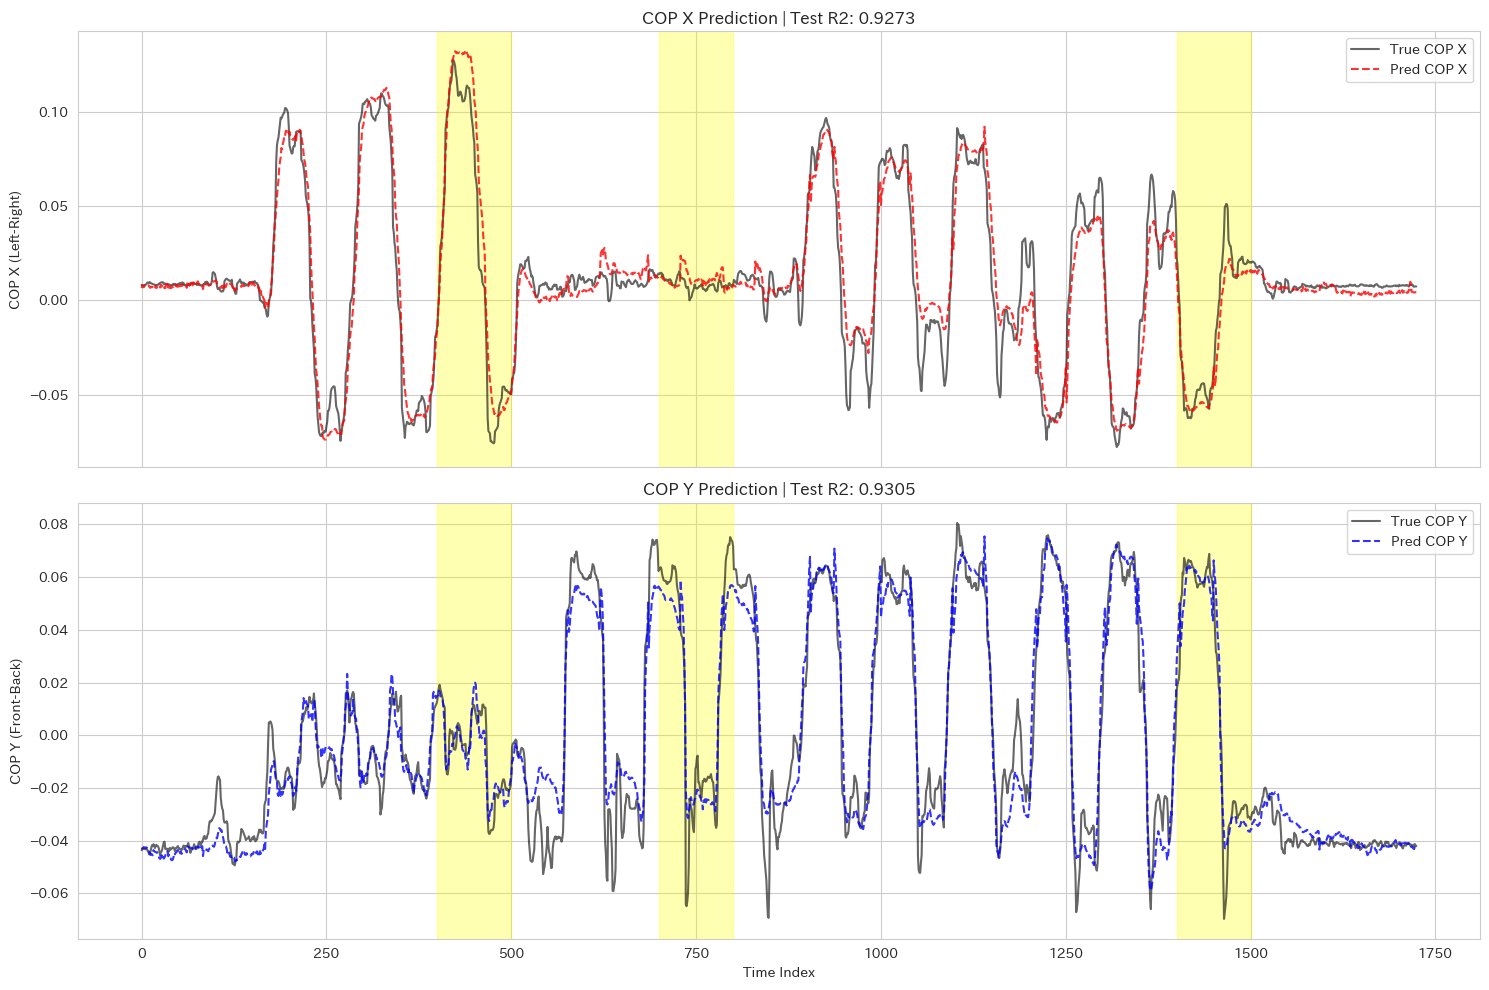

Train R2 COP_X: 0.9215203128409568
Train R2 COP_Y: 0.9357934357691853


In [27]:
# --- Cell 6 (改良版): Custom Split Evaluation (COP X & Y 両方を表示) ---
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error, r2_score

# 1. テストデータの区間定義 (start, end)
test_ranges = [
    (400, 500),
    (700, 800),
    (1400, 1500)
]

# 2. マスク（フィルタ）の作成
n_samples = len(X)
is_test_mask = np.zeros(n_samples, dtype=bool)

for start, end in test_ranges:
    s = max(0, start)
    e = min(n_samples, end)
    is_test_mask[s:e] = True

# 3. データの分割
X_train = X[~is_test_mask]
y_train = y[~is_test_mask]

X_test = X[is_test_mask]
y_test = y[is_test_mask]

print(f"学習データ数: {len(X_train)}")
print(f"テストデータ数: {len(X_test)}")

# 4. モデル構築と学習
custom_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))
])

custom_model.fit(X_train, y_train)

# 5. テストデータに対する評価 (個別スコア計算)
y_pred_test = custom_model.predict(X_test)

# 全体のスコア
r2_total = r2_score(y_test, y_pred_test)

# X軸 (左右) と Y軸 (前後) 個別のスコア
r2_x = r2_score(y_test.iloc[:, 0], y_pred_test[:, 0])
r2_y = r2_score(y_test.iloc[:, 1], y_pred_test[:, 1])
rmse_x = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred_test[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred_test[:, 1]))

print("-" * 40)
print(f"Test Ranges: {test_ranges}")
print(f"Total R2 Score: {r2_total:.4f}")
print(f"COP_X (左右) -> R2: {r2_x:.4f}, RMSE: {rmse_x:.3f}")
print(f"COP_Y (前後) -> R2: {r2_y:.4f}, RMSE: {rmse_y:.3f}")
print("-" * 40)

# 6. 可視化（XとYを上下に並べて表示）
y_pred_all = custom_model.predict(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# --- 上段: COP X ---
ax1.plot(y.values[:, 0], label='True COP X', color='black', alpha=0.6)
ax1.plot(y_pred_all[:, 0], label='Pred COP X', color='red', linestyle='--', alpha=0.8)
ax1.set_ylabel("COP X (Left-Right)")
ax1.set_title(f"COP X Prediction | Test R2: {r2_x:.4f}")
ax1.legend(loc='upper right')
ax1.grid(True)

# --- 下段: COP Y ---
ax2.plot(y.values[:, 1], label='True COP Y', color='black', alpha=0.6)
ax2.plot(y_pred_all[:, 1], label='Pred COP Y', color='blue', linestyle='--', alpha=0.8)
ax2.set_ylabel("COP Y (Front-Back)")
ax2.set_title(f"COP Y Prediction | Test R2: {r2_y:.4f}")
ax2.set_xlabel("Time Index")
ax2.legend(loc='upper right')
ax2.grid(True)

# --- テスト区間のハイライト (両方のグラフに適用) ---
for ax in [ax1, ax2]:
    for start, end in test_ranges:
        if end > len(y): break
        # 凡例に一度だけ表示させるための工夫
        label_name = 'Test Range' if (ax == ax1 and start == test_ranges[0][0]) else ""
        ax.axvspan(start, end, color='yellow', alpha=0.3, label=label_name)

plt.tight_layout()
plt.show()


y_pred_train = custom_model.predict(X_train)

print("Train R2 COP_X:", r2_score(y_train.iloc[:,0], y_pred_train[:,0]))
print("Train R2 COP_Y:", r2_score(y_train.iloc[:,1], y_pred_train[:,1]))

In [22]:
# R2 Score がマイナスになるのは、**「学習データの分布と、テストデータの分布が全く異なる（共変量シフト）ときに起こります。

<Figure size 1200x1000 with 0 Axes>

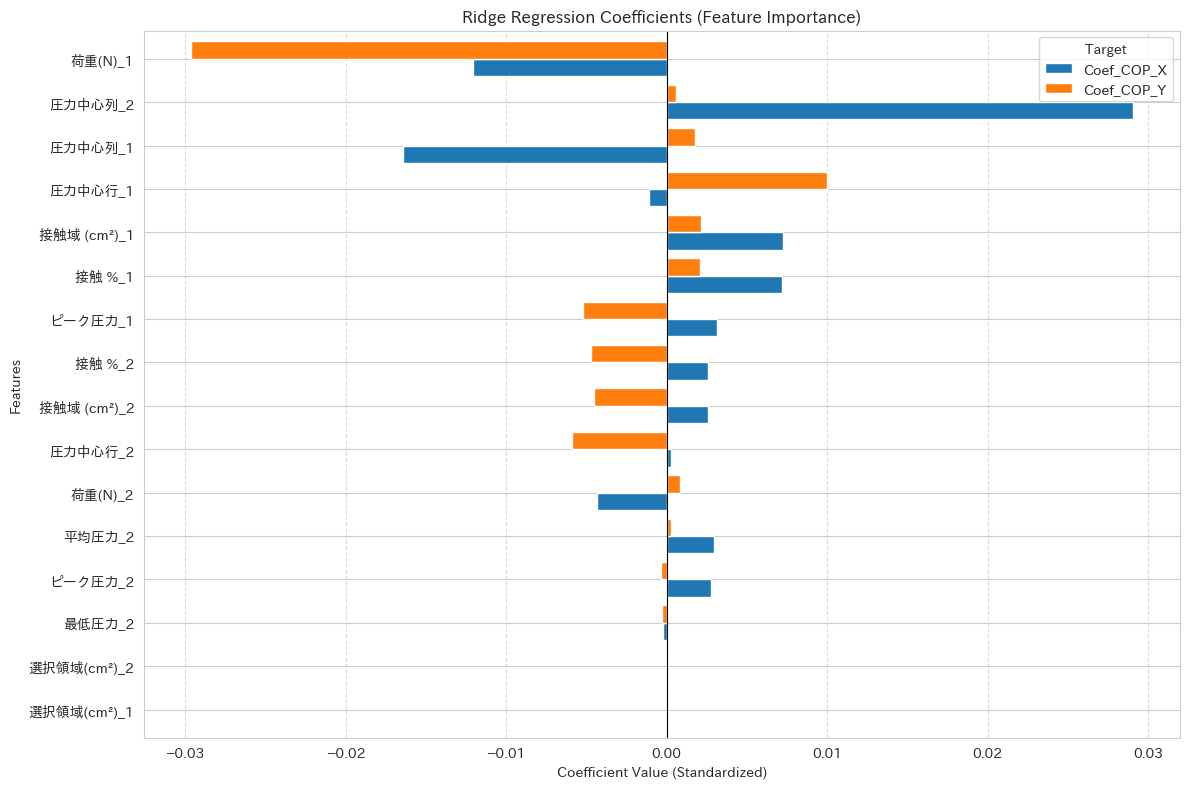

--- Top 5 Important Features for COP X (Left-Right) ---
圧力中心列_2        0.029055
圧力中心列_1       -0.016405
荷重(N)_1       -0.012066
接触域 (cm²)_1    0.007280
接触 %_1         0.007204
Name: Coef_COP_X, dtype: float64

--- Top 5 Important Features for COP Y (Front-Back) ---
荷重(N)_1   -0.029624
圧力中心行_1    0.009980
圧力中心行_2   -0.005903
ピーク圧力_1   -0.005237
接触 %_2    -0.004709
Name: Coef_COP_Y, dtype: float64


In [23]:
# --- Cell 7: Feature Importance Visualization ---
import seaborn as sns

# 1. パイプラインからRidgeモデルと係数を取得
# custom_model.named_steps['regressor'] でRidgeオブジェクトにアクセス
ridge_model = custom_model.named_steps['regressor']
coefs = ridge_model.coef_  # Shape: (2, n_features) -> (COP_X, COP_Y)

# 特徴量名
feature_names = features

# 2. データフレームにまとめる
df_coef = pd.DataFrame(
    coefs.T, 
    columns=['Coef_COP_X', 'Coef_COP_Y'], 
    index=feature_names
)

# 3. 重要度（絶対値の合計）でソート
df_coef['Abs_Importance'] = df_coef.abs().sum(axis=1)
df_coef_sorted = df_coef.sort_values(by='Abs_Importance', ascending=True) # グラフ用に昇順

# 不要な列（ソート用）を削除して、プロット用データ作成
plot_data = df_coef_sorted[['Coef_COP_X', 'Coef_COP_Y']]

# 4. 可視化 (水平棒グラフ)
plt.figure(figsize=(12, 10))

# pandasのplot機能を使用
plot_data.plot(kind='barh', figsize=(12, 8), width=0.8)

plt.title("Ridge Regression Coefficients (Feature Importance)")
plt.xlabel("Coefficient Value (Standardized)")
plt.ylabel("Features")
plt.axvline(x=0, color='black', linewidth=0.8) # ゼロライン
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Target")

plt.tight_layout()
plt.show()

# 5. 上位5つの重要な特徴量を表示
print("--- Top 5 Important Features for COP X (Left-Right) ---")
top_x = df_coef['Coef_COP_X'].abs().sort_values(ascending=False).head(5)
print(df_coef.loc[top_x.index, 'Coef_COP_X'])

print("\n--- Top 5 Important Features for COP Y (Front-Back) ---")
top_y = df_coef['Coef_COP_Y'].abs().sort_values(ascending=False).head(5)
print(df_coef.loc[top_y.index, 'Coef_COP_Y'])

横軸：標準化後の係数値（寄与の大きさ）
縦軸：特徴量

青：COP_X に効く特徴量
オレンジ：COP_Y に効く特徴量
正 → 増える方向に効く
負 → 減る方向に効く

COP_X（左右）の予測に効いているもの（青）
1位：圧力中心列_2（非常に強い）
右座面 or 右後方センサの COP 横方向を直接反映していると思われる

横方向 COP_X の最重要特徴量
2位：圧力中心列_1（やや強い）

同上の左側センサの COP 横方向成分
➡ COP_X は「左右方向」に関係する特徴（圧力中心列）が強く効いている
物理的に見ても非常に妥当。


COP_Y（前後）の予測に効いているもの（オレンジ）
1位：圧力中心行_1
前後方向の COP_Y を直接反映している特徴
最重要
2位：圧力中心行_2
第二の前後方向 COP 情報
➡ COP_Y は「前後方向」の情報（圧力中心行）が強い寄与
こちらも物理的に非常に自然。


✅ 見方②：興味深い点・気づき
特徴：荷重(N)_1 の COP_Y 寄与が異常に大きい

オレンジ（COP_Y）で 荷重(N)_1 が大きくマイナスに出ている。

これはどう解釈する？

体重が前に寄ると、座圧センサ1側の荷重が増える？

その結果、COP_Y が後ろ方向にずれる or 逆方向に補正している？

いずれにせよ 体重の偏り（左右または前後）を反映している と考えられる。

注意点

荷重が効きすぎている場合：

他の特徴量がその効果を十分表現できていない

標準化後でも荷重の分布が他特徴と異なる

データ欠損・キャリブレーションの差

などの可能性も検討が必要。

✅ 見方③：左右・前後の独立性が見えている

このグラフは、本来人間が椅子に座ったときに起こる力学をよく反映しています。

特徴量	COP_X への寄与	COP_Y への寄与	解釈
圧力中心列（左右方向）	大きい	小さい	左右位置の決め手
圧力中心行（前後方向）	小さい	大きい	前後位置の決め手
荷重(N)	中程度	大きい	体重の偏りが COP に大きく影響
接触面積・接触％・平均圧	小さい	小さい	COP 位置の決定に直接は効かない

これは「COP（圧力中心）」を決める物理法則をそのまま表しています。



以下はほぼゼロに張り付いていて、Ridge 回帰はこれらを無視しています：
選択領域（cm²）
最低圧力
ピーク圧力
接触 %
接触域 (cm²)
平均圧力
➡ 今後のモデル軽量化では削減候補

最適なalphaを探索中...
★ 最適な alpha: 1.0
----------------------------------------
Train R2 Score: 0.9287
Test  R2 Score: 0.9289
Gap (Train - Test): -0.0003
判定: ❓ テストデータの方がスコアが良い (データ分布の偏りの可能性)
----------------------------------------


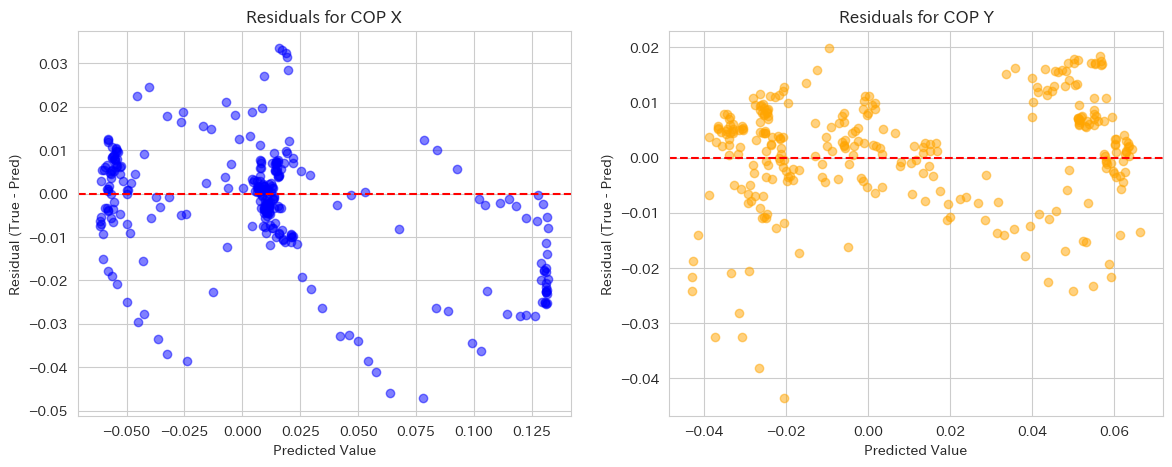

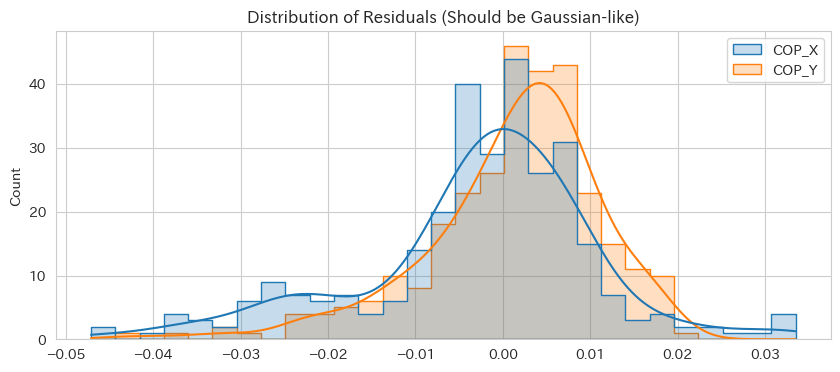

In [29]:
# --- Cell 8: Robustness Check (過学習確認 & パラメータ探索) ---
from sklearn.linear_model import RidgeCV

# 1. ハイパーパラメータ探索 (RidgeCV)
# alpha（正則化の強さ）を 0.1 ~ 1000 の範囲で自動で試してベストを探す
alphas = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# Cross-Validation付きのRidge
ridge_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas=alphas, scoring='r2'))
])

print("最適なalphaを探索中...")
ridge_cv.fit(X_train, y_train)

# ベストなalphaを表示
best_alpha = ridge_cv.named_steps['regressor'].alpha_
print(f"★ 最適な alpha: {best_alpha}")
if best_alpha == max(alphas):
    print("警告: alphaが探索範囲の上限です。もっと大きな値を試すべきかもしれません。")

# 2. 過学習の確認 (Train vs Test Score)
y_pred_train = ridge_cv.predict(X_train)
y_pred_test = ridge_cv.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("-" * 40)
print(f"Train R2 Score: {r2_train:.4f}")
print(f"Test  R2 Score: {r2_test:.4f}")
print(f"Gap (Train - Test): {r2_train - r2_test:.4f}")

if r2_train - r2_test > 0.15:
    print("判定: ⚠️ 過学習の疑いあり (学習データに適合しすぎています)")
elif r2_test > r2_train:
    print("判定: ❓ テストデータの方がスコアが良い (データ分布の偏りの可能性)")
else:
    print("判定: ✅ 良好な汎化性能 (Gapが小さい)")
print("-" * 40)

# 3. 残差プロット (Residual Plot)
# 予測値と、実際の値とのズレ（残差）をプロットします
residuals = y_test - y_pred_test

plt.figure(figsize=(14, 5))

# X軸方向の残差
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test[:, 0], residuals.iloc[:, 0], alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals for COP X")
plt.xlabel("Predicted Value")
plt.ylabel("Residual (True - Pred)")
plt.grid(True)

# Y軸方向の残差
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test[:, 1], residuals.iloc[:, 1], alpha=0.5, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals for COP Y")
plt.xlabel("Predicted Value")
plt.ylabel("Residual (True - Pred)")
plt.grid(True)

plt.show()

# 残差のヒストグラム（正規分布に近いか？）
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True, element="step")
plt.title("Distribution of Residuals (Should be Gaussian-like)")
plt.show()